# 6장 과제

각 사례분석에서 overfitting 해결하기.  즉, 모수초기치, 활성함수, dropout, 노드수나 kernel size 를 조절하여 모수 줄이기, VGG16 의 input size 줄이기, regularization, normalization 등을 이용하여 overfitting 을 해결하기.

## Task1. male vs female

data 준비

In [1]:
import pandas as pd 
from skimage import io

#출판사에서 다운받기
data=pd.read_csv('D:/deepdata/a943287.csv') #excel 데이터. csv는 빈칸이 , 로 되어있음
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42
2,1023132477,False,finalized,1,8/19/2016 17:01:43,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...,NaN,44
3,1023132478,False,finalized,1,8/19/2016 17:01:04,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...,NaN,47
4,1023132479,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...,NaN,50


In [2]:
data_male=data[data['please_select_the_gender_of_the_person_in_the_picture']=='male']
data_female=data[data['please_select_the_gender_of_the_person_in_the_picture']=='female']
final_data=pd.concat([data_male[:1000],data_female[:1000]], axis=0).reset_index(drop=True) #axis 0 니까 sample size 1000개씩 쪼갬
final_data.shape

(2000, 10)

In [3]:
x=[]
y=[]
for i in range(final_data.shape[0]): #2000개
    if i in [13,699,946,1222,1469,1623]:
        continue
    try:
        image=io.imread(final_data.loc[i]['image_url']) #pandas data라서 loc로 함. imread로 이미지를 읽음.
        if (image.shape==(300,300,3)): #pixel 300X300, 컬러데이터
            x.append(image) #이미지
            y.append(final_data.loc[i]['please_select_the_gender_of_the_person_in_the_picture']) #male/female
    except:
        continue

In [4]:
print(len(x),len(y))

1728 1728


In [5]:
#!pip install opencv-python #computer vision 패키지 설치
import cv2 
import numpy as np

x2=[]
y2=[]
for i in range(len(x)):
    img2=cv2.resize(x[i],(200,200)) #메모리 한계로 더 크게 resize 못함
    x2.append(img2)
    img_label=np.where(y[i]=='male',1,0) #male이면 1, 아니면 0 => one-hot encoding 으로 바꿔줌
    y2.append(img_label)

In [6]:
x2=np.array(x2) #list data -> tensor data 로 고쳐줌 (numpy로 해도 ok)
print(x2.shape) 
y1=np.array(y2)
x1=x2.astype('float32')/255.

(1728, 200, 200, 3)


In [7]:
from sklearn.model_selection import train_test_split

# 10% 를 test data로 만듦. stratify random sampling / y의 비율이 똑같도록. 층화추출법. train/test 쪼갤 때 남/여 비율 똑같이 맞춤
x_train,x_test,y_train,y_test=train_test_split(x1,y1,test_size=0.1,random_state=1, stratify=y)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(1555, 200, 200, 3) (173, 200, 200, 3) (1555,) (173,)


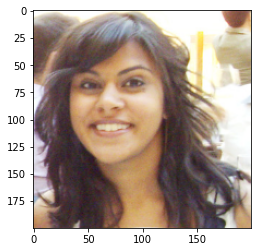

In [8]:
import matplotlib.pyplot as plt
plt.imshow(x_train[1])
plt.show()

### 1) Basic CNN Model

model

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense
from tensorflow.keras.models import Sequential

model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=[200,200,3]))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(256,(3,3),activation='relu',padding='same'))
model.add(Flatten())
#아래 두개는 통계모형임. 로지스틱회귀. 만약 두번째줄에 10개면 softmax 쓰고 log linear model. 
model.add(Dense(100,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 99, 99, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       2

compile, fit

In [14]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['acc'])
result=model.fit(x_train,y_train,batch_size=32,epochs=30,validation_data=(x_test,y_test))
score=model.evaluate(x_test,y_test)
print(score)

graph

In [ ]:
import matplotlib.pyplot as plt
acc=result.history['acc']
val_acc=result.history['val_acc']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='training accuracy')
plt.plot(epochs, val_acc,'b',label='validation accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs, val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

evaluate

In [ ]:
result2 = model.evaluate(x_test,y_test, batch_size=128)
print(result2)

* 해당 모델에서 train loss는 거의 0에 수렴하지만 validation loss는 증가하는 것으로 보아 과대적합이 심각하게  발생하고 있음을 알 수 있다.  
* 이 는 매우 큰 수의 모수를 단 1700여개의 표본으로 학습했기 때문이다.
* 다음에서는 이미 많은 양의 데이터로 학습된 모델을 사용하는 이전학습을 통해 모델의 성능을 증가시켜본다.

### 2) VGG 이용한 Model
* 140만개의 이미지 자료로 구축된 VGG16 모델을 기초로 이전학습한다.
* 기존 input 데이터를 MLP이후의 층을 제외한 vgg 모델의 convolution 부분에 통과시켜 새로운 input 데이터를 생성한다. 
* 이 때  imagenet 데이터로 학습된 vgg 모델의 weight을 사용한다.

load vgg16 model

In [11]:
from tensorflow.keras.applications import VGG16

#include_top=False 로 인해 Dense 인 MLP 층을 제외함. 
#우리의 MLP 층을 붙여서 우리 데이터를 학습.
vgg16_model=VGG16(weights='imagenet',include_top=False,input_shape=(300,300,3))
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [ ]:
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input

x5_vgg16=[]
y5=[]
for i in range(len(x)): #우리 데이터: 2000장
    img=x[i]
    img=preprocess_input(img.reshape(1,300,300,3)) #vgg의 input이 4D dimension으로 들어가야됨. 1장씩 들어감.
    img_new=vgg16_model.predict(img)
    x5_vgg16.append(img_new)
    img_label=np.where(y[i]=='male',1,0) # 1 or 0 
    y5.append(img_label)

In [ ]:
x5_vgg16=np.array(x5_vgg16)
print(x5_vgg16.shape)
# [1] 을 버려야됨 -> 다시 reshape
x5_vgg16=x5_vgg16.reshape(x5_vgg16.shape[0],x5_vgg16.shape[2],x5_vgg16.shape[3],x5_vgg16.shape[4])
y5=np.array(y5)

In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x5_vgg16,y5,test_size=0.1,random_state=1, stratify=y5)

model

In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Flatten, Dropout
from tensorflow.keras.models import Sequential

modelvgg16=Sequential()
modelvgg16.add(Conv2D(512,(3,3),activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])))
modelvgg16.add(MaxPooling2D((2,2)))
modelvgg16.add(Flatten())
modelvgg16.add(Dense(512,activation='relu'))
modelvgg16.add(Dropout(0.5))
modelvgg16.add(Dense(1,activation='sigmoid'))
modelvgg16.summary()

compile, fit

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
#callback_list = [EarlyStopping(monitor='accuracy',patience=2)]
modelvgg16.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_vgg16=modelvgg16.fit(x_train/np.max(x_train),y_train,batch_size=32,epochs=10,validation_data=(x_test/np.max(x_train),y_test))#,callbacks=callback_list)

graph

In [ ]:
import matplotlib.pyplot as plt
acc=history_vgg16.history['accuracy']
val_acc=history_vgg16.history['val_accuracy']
loss=history_vgg16.history['loss']
val_loss=history_vgg16.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='training accuracy')
plt.plot(epochs, val_acc,'b',label='validation accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs, val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

evaluate

In [ ]:
result2 = modelvgg16.evaluate(x_test,y_test, batch_size=128)
print(result2)

* 앞선 모델에|서 accuracy가 0.6590이었던 것에 비하면 accuracy는 0.92로 많이 증가하였다. 
* 하지만 여전히 validation data가 train data의 정확도에 못미친다는 점에서 모델을 조정할 필요가 있다.
* 이번에는 같은 모델에 overfitting 해결에 효과적인 dropout & batchnormalization 방법을 적용해 본다.

### 3) VGG + dropout & batchnormalization 방법을 적용한 model

In [ ]:
from tensorflow.keras.layers import BatchNormalization

model2_vgg16=Sequential()
model2_vgg16.add(Conv2D(512,(3,3),activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])))
model2_vgg16.add(BatchNormalization(momentum=0.9)) #batchnorm
model2_vgg16.add(MaxPooling2D((2,2)))
model2_vgg16.add(Dropout(0.3))

model2_vgg16.add(Flatten())
model2_vgg16.add(Dense(512,activation='relu')) 
model2_vgg16.add(BatchNormalization(momentum=0.9)) #batchnorm
model2_vgg16.add(Dropout(0.5))

model2_vgg16.add(Dense(1,activation='sigmoid'))
model2_vgg16.summary()

compile, fit

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
#callback_list = [EarlyStopping(monitor='accuracy',patience=2)]
model2_vgg16.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2_vgg16=model2_vgg16.fit(x_train/np.max(x_train),y_train,batch_size=32,epochs=10,validation_data=(x_test/np.max(x_train),y_test))#,callbacks=callback_list)

graph

In [ ]:
import matplotlib.pyplot as plt

acc=history2_vgg16.history['accuracy']
val_acc=history2_vgg16.history['val_accuracy']
loss=history2_vgg16.history['loss']
val_loss=history2_vgg16.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='training accuracy')
plt.plot(epochs, val_acc,'b',label='validation accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs, val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

evaluate

In [ ]:
result3 = model2_vgg16.evaluate(x_test,y_test, batch_size=128)
print(result3)

* train accuracy는 1인 에 반해 validation accuracy는 0.88로 train data에 과대 적합된 모습을 확인할 수 있다. 

### 4) VGG + dropout & batchnormalization 방법 + 출력층 직전의 노드수 줄이기
이번에는 모수 수를 줄이기 위해  위와 같은 모델에서 출력층 직전의 노드수를 줄여보았다.

In [17]:
from tensorflow.keras.layers import BatchNormalization

model3_vgg16=Sequential()
model3_vgg16.add(Conv2D(512,(3,3),activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])))
model3_vgg16.add(BatchNormalization(momentum=0.9)) #batchnorm
model3_vgg16.add(MaxPooling2D((2,2)))
model3_vgg16.add(Dropout(0.3))

model3_vgg16.add(Flatten())
model3_vgg16.add(Dense(64,activation='relu')) #512->64
model3_vgg16.add(BatchNormalization(momentum=0.9)) #batchnorm
model3_vgg16.add(Dropout(0.5))

model3_vgg16.add(Dense(1,activation='sigmoid'))
model3_vgg16.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 512)     14336     
_________________________________________________________________
batch_normalization (BatchNo (None, 198, 198, 512)     2048      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 512)       0         
_________________________________________________________________
dropout (Dropout)            (None, 99, 99, 512)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5018112)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                321159232 
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)               

compile, fit

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
#callback_list = [EarlyStopping(monitor='accuracy',patience=2)]
model3_vgg16.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3_vgg16=model3_vgg16.fit(x_train/np.max(x_train),y_train,batch_size=32,epochs=10,validation_data=(x_test/np.max(x_train),y_test))#,callbacks=callback_list)

graph

In [ ]:
import matplotlib.pyplot as plt

acc=history3_vgg16.history['accuracy']
val_acc=history3_vgg16.history['val_accuracy']
loss=history3_vgg16.history['loss']
val_loss=history3_vgg16.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='training accuracy')
plt.plot(epochs, val_acc,'b',label='validation accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs, val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

evaluate

In [ ]:
result3 = model3_vgg16.evaluate(x_test,y_test, batch_size=128)
print(result3)

* accuracy 가 0.913 으로 높게 나타났다. 
    * 하지만 여전히 과대적합이 일어나고 있다.
    * 다음에는 출력층에 규제화를 적용해 모수 수를 이는 효과를 얻어본다.

### 5) VGG + dropout & batchnormalization 방법 + 출력층에 L1규제화

In [ ]:
from tensorflow.keras.layers import BatchNormalization

model3_vgg16=Sequential()
model3_vgg16.add(Conv2D(512,(3,3),activation='relu',input_shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3])))
model3_vgg16.add(BatchNormalization(momentum=0.9)) #batchnorm
model3_vgg16.add(MaxPooling2D((2,2)))
model3_vgg16.add(Dropout(0.3))

model3_vgg16.add(Flatten())
model3_vgg16.add(Dense(512,activation='relu')) 
model3_vgg16.add(BatchNormalization(momentum=0.9)) #batchnorm
model3_vgg16.add(Dropout(0.5))

model3_vgg16.add(Dense(1,activation='sigmoid', kernel_regularizer='l1'))
model3_vgg16.summary()

compile, fit

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
callback_list = [EarlyStopping(monitor='accuracy',patience=3)]

model3_vgg16.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3_vgg16=model3_vgg16.fit(x_train/np.max(x_train),y_train,batch_size=32,epochs=20,validation_data=(x_test/np.max(x_train),y_test),callbacks=callback_list)

graph

In [ ]:
import matplotlib.pyplot as plt

acc=history3_vgg16.history['accuracy']
val_acc=history3_vgg16.history['val_accuracy']
loss=history3_vgg16.history['loss']
val_loss=history3_vgg16.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'bo',label='training accuracy')
plt.plot(epochs, val_acc,'b',label='validation accuracy')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'bo',label='training loss')
plt.plot(epochs, val_loss,'b',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

evaluate

In [ ]:
result4 = model3_vgg16.evaluate(x_test,y_test, batch_size=128)
print(result4)

* 그래프를 보면 단순히 출력층 직전의 노드수를 줄여서 모수를 줄였을 때 보다 출력층에 규제화를 적용했을 때 validation loss의 noise가 적음을 알 수 있다.
* accuracy 가 0.913 으로 높게 나타났다. 
    * 하지만 여전히 과대적합이 일어나고 있다.
* imagenet으로 학습된 vgg model을 그대로 사용하는 대신, vgg model의 일부를 우리 data로 학습시키면 어느정도 개선될 것으로 생각된다. 
    * 따라서 다음에는 Fine Tuning을 시도해 본다

### 6) Fine Tuning을 적용
* 이미 천사백만개 모수가 train 되어있는 vgg model 의 출력층과 함께 vgg model의 일부 층을 다시 학습한다.
* 위에서 과대적합 개선과 성능 개선에 효과가 있었던 자료증대도 함께 사용한다.

In [17]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x1,y1,test_size=0.1,random_state=1, stratify=y)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(1555, 200, 200, 3) (173, 200, 200, 3) (1555,) (173,)


load vgg weight

In [18]:
from tensorflow.keras.applications import VGG16
vgg_base=VGG16(weights='imagenet',include_top=False, input_shape=(200,200,3))
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model_fine = Sequential()
model_fine.add(vgg_base) #vgg 모델
model_fine.add(Flatten())
model_fine.add(Dense(256,activation='relu'))
model_fine.add(Dense(1,activation='sigmoid'))
model_fine.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 19,433,793
Trainable params: 19,433,793
Non-trainable params: 0
_________________________________________________________________


In [20]:
vgg_base.trainable=True #True로 풀어줌.
trainable_layer=False #변수

for layer in vgg_base.layers: #vgg의 layer하나하나를 읽음
    if layer.name=='block5_conv1': # block5_conv1부터 trainable_layer가 True로 layer.trainable이 True로 바뀜
        trainable_layer=True 
        #False를 True로 바꿈. 한번 True로 걸리면 그 뒤에 층들은 다 trainable=True임
    if trainable_layer:
        layer.trainable=True
    else:
        layer.trainable=False

compile, fit

In [23]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

callback_list = [EarlyStopping(monitor='acc',patience=2)]

model_fine.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])
result=model_fine.fit(x_train,y_train,batch_size=32,epochs=30,validation_data=(x_test,y_test))

Epoch 1/30
49/49 [==============================] - 829s 17s/step - loss: 0.4443 - acc: 0.7848 - val_loss: 0.3839 - val_acc: 0.8035
Epoch 2/30
49/49 [==============================] - 829s 17s/step - loss: 0.2744 - acc: 0.8958 - val_loss: 0.3016 - val_acc: 0.8728
Epoch 3/30
49/49 [==============================] - 861s 18s/step - loss: 0.1529 - acc: 0.9608 - val_loss: 0.3563 - val_acc: 0.8382
Epoch 4/30
49/49 [==============================] - 827s 17s/step - loss: 0.1066 - acc: 0.9765 - val_loss: 0.3460 - val_acc: 0.8497
Epoch 5/30
49/49 [==============================] - 825s 17s/step - loss: 0.0602 - acc: 0.9891 - val_loss: 0.5759 - val_acc: 0.7861
Epoch 6/30
49/49 [==============================] - 863s 18s/step - loss: 0.0470 - acc: 0.9920 - val_loss: 0.3016 - val_acc: 0.8728
Epoch 7/30
49/49 [==============================] - 868s 18s/step - loss: 0.0275 - acc: 0.9940 - val_loss: 0.3299 - val_acc: 0.8671
Epoch 8/30
14/49 [=======>......................] - ETA: 9:22 - loss: 0.0094

KeyboardInterrupt: 

graph

In [25]:
import matplotlib.pyplot as plt
acc=result.history['acc']
val_acc=result.history['val_acc']
loss=result.history['loss']
val_loss=result.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

evaluate

In [ ]:
score=model_fine.evaluate(x_test,y_test)
print(score)

### 7) Fine Tuning + 모수 초기치 부여, 규제화 적용, batchnormalization, dropout 의 기법

model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout

model_fine2 = Sequential()
model_fine2.add(vgg_base) #vgg 모델
model_fine2.add(Flatten())
model_fine2.add(Dense(256,activation='relu',kernel_initializer='he_normal')) #he initializer
model_fine2.add(BatchNormalization(momentum=0.9)) #batchnorm
model_fine2.add(Dropout(0.5)) #dropout
model_fine2.add(Dense(1,activation='sigmoid',kernel_regularizer='l1')) #L1 norm
model_fine2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4718848   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 19,434,817
Trainable params: 19,434,305
Non-trainable params: 512
________________________________________

In [15]:
vgg_base.trainable=True #True로 풀어줌.
trainable_layer=False #변수

for layer in vgg_base.layers: #vgg의 ayer하나하나를 읽음
    if layer.name=='block5_conv1': # block5_conv1부터 trainable_layer가 True로 layer.trainable이 True로 바뀜
        trainable_layer=True 
        #False를 True로 바꿈. 한번 True로 걸리면 그 뒤에 층들은 다 trainable=True임
    if trainable_layer:
        layer.trainable=True
    else:
        layer.trainable=False

compile, fit

In [26]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

callback_list = [EarlyStopping(monitor='acc',patience=3)]

model_fine2.compile(optimizer=optimizers.RMSprop(lr=2e-5),loss='binary_crossentropy',metrics=['acc'])
model_fine_result2=model_fine2.fit(x_train,y_train,batch_size=16,epochs=40,validation_data=(x_test,y_test))

graph

In [ ]:
import matplotlib.pyplot as plt
acc=model_fine_result2.history['acc']
val_acc=model_fine_result2.history['val_acc']
loss=model_fine_result2.history['loss']
val_loss=model_fine_result2.history['val_loss']
epochs=range(1,len(acc)+1)
plt.plot(epochs,acc,'b',label='training acc')ㅠ
plt.plot(epochs,val_acc,'bo',label='validation acc')
plt.title('training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs,loss,'b',label='training loss')
plt.plot(epochs,val_loss,'bo',label='validation loss')
plt.title('training and validation loss')
plt.legend()
plt.show()

evaluate

In [ ]:
score=model_fine2.evaluate(x_test,y_test)
print(score)